In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import imageio
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import box, Polygon
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import matplotlib.font_manager as font_manager
font_files = font_manager.findSystemFonts()

# Labeling results

Steps to polygonize the labels were done in Descartes Labs, and areas of the polygons were computed in Google Earth Engine.

In [5]:
polygons = gpd.read_file('../mount/data/GeneralBlockchain/campaign_results/india_fields_with_area.shp')

In [3]:
polygons.shape

(10013, 3)

In [4]:
polygons.head()

,area,sample,geometry
0,9620.550048,0,"POLYGON ((73.10624 26.30254, 73.10624 26.30257..."
1,5244.485268,0,"POLYGON ((73.10746 26.30160, 73.10746 26.30162..."
2,1983.845942,0,"POLYGON ((73.10792 26.30120, 73.10792 26.30122..."
3,5191.243054,0,"POLYGON ((73.10543 26.29889, 73.10543 26.29893..."
4,5728.435942,0,"POLYGON ((73.10319 26.29923, 73.10325 26.29923..."


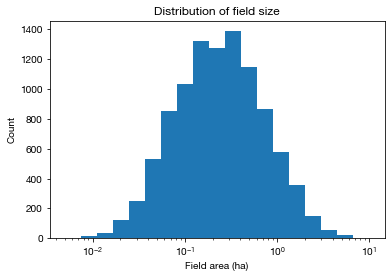

In [5]:
plt.hist(polygons['area'] / 10000, bins=np.logspace(-2.3,1,20))
plt.xscale('log')
plt.title('Distribution of field size')
plt.xlabel('Field area (ha)')
plt.ylabel('Count')
plt.show()

In [6]:
bbox_df = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_v1.csv')

# Sample image centers

In [6]:
min_lons = []
min_lats = []
max_lons = []
max_lats = []
for i, row in polygons.iterrows():
    lons = row['geometry'].exterior.coords.xy[0]
    lats = row['geometry'].exterior.coords.xy[1]
    min_lons.append(np.min(lons))
    min_lats.append(np.min(lats))
    max_lons.append(np.max(lons))
    max_lats.append(np.max(lats))

In [7]:
polygons['min_lon'] = min_lons
polygons['min_lat'] = min_lats
polygons['max_lon'] = max_lons
polygons['max_lat'] = max_lats

In [8]:
mins = polygons[['sample', 'min_lon', 'min_lat']].groupby('sample').min().reset_index()
maxs = polygons[['sample', 'max_lon', 'max_lat']].groupby('sample').max().reset_index()

In [9]:
df = mins.merge(maxs, on='sample', how='inner')

In [10]:
df['dx'] = 1./(111111. * np.cos(df['min_lat'] * np.pi / 180.)) * 214 * 3
dy = 1./111111. * 214 * 3

df['min_lon_for_sampling'] = df['max_lon'] - df['dx']
df['max_lon_for_sampling'] = df['min_lon'] + df['dx']
df['min_lat_for_sampling'] = df['max_lat'] - dy
df['max_lat_for_sampling'] = df['min_lat'] + dy

In [13]:
# sample image centers from bounds
samples = []
bbox_min_lons = []
bbox_min_lats = []
bbox_max_lons = []
bbox_max_lats = []

for i, row in df.iterrows():
    count = 0
    
    while count < 3:
        x = np.random.uniform(low=row['min_lon_for_sampling'], high=row['max_lon_for_sampling'])
        y = np.random.uniform(low=row['min_lat_for_sampling'], high=row['max_lat_for_sampling'])

        box_min_lon = x - row['dx']
        box_max_lon = x + row['dx']
        box_min_lat = y - dy
        box_max_lat = y + dy

        bbox = box(box_min_lon, box_min_lat, box_max_lon, box_max_lat)

        intersects = False
        polys = polygons[polygons['sample'] == row['sample']]
        for j, poly in polys.iterrows():
            if poly['geometry'].intersects(bbox):
                intersects = True
        if intersects:
            count += 1
            samples.append(row['sample'])
            bbox_min_lons.append(box_min_lon)
            bbox_min_lats.append(box_min_lat)
            bbox_max_lons.append(box_max_lon)
            bbox_max_lats.append(box_max_lat)

In [14]:
# bbox dataframe housing bounding boxes for Planet images
image_ids = [str(x).zfill(4) + y for x, y in list(
    zip(np.array(samples, dtype=int), ['a', 'b', 'c'] * (len(samples) // 3)))]
bbox_df = pd.DataFrame({
    "image_id": image_ids,
    "min_lon": bbox_min_lons,
    "min_lat": bbox_min_lats,
    "max_lon": bbox_max_lons,
    "max_lat": bbox_max_lats
})

In [16]:
bbox_df.to_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_v1.csv', index=False)

In [18]:
bbox_df.head()

,image_id,min_lon,min_lat,max_lon,max_lat
0,0001a,77.431186,25.711210,77.444012,25.722766
1,0001b,77.434433,25.709826,77.447259,25.721382
2,0001c,77.426457,25.713601,77.439283,25.725157
3,0002a,76.598109,27.190678,76.611101,27.202234
4,0002b,76.598915,27.189477,76.611906,27.201033


In [64]:
# bbox dataframe for maximum extent of Planet images we will want to download
bbox_df_download = df[['sample', 'min_lon_for_sampling', 'min_lat_for_sampling',
    'max_lon_for_sampling', 'max_lat_for_sampling']].rename({
    'min_lon_for_sampling': 'min_lon',
    'min_lat_for_sampling': 'min_lat',
    'max_lon_for_sampling': 'max_lon',
    'max_lat_for_sampling': 'max_lat'
}, axis=1)
bbox_df_download['min_lon'] = bbox_df_download['min_lon'] - df['dx']
bbox_df_download['max_lon'] = bbox_df_download['max_lon'] + df['dx']
bbox_df_download['min_lat'] = bbox_df_download['min_lat'] - dy
bbox_df_download['max_lat'] = bbox_df_download['max_lat'] + dy
bbox_df_download['image_id'] = bbox_df_download['sample'].astype(str).str.zfill(4)

In [65]:
bbox_df_download = bbox_df_download.drop('sample', axis=1)[
    ['image_id', 'min_lon', 'min_lat', 'max_lon', 'max_lat']]
bbox_df_download.head()

,image_id,min_lon,min_lat,max_lon,max_lat
0,0000,73.095543,26.291410,73.116079,26.309582
1,0001,77.426281,25.708583,77.447435,25.727361
2,0002,76.594832,27.184024,76.614239,27.202949
3,0003,80.584134,27.467418,80.607517,27.485268
4,0004,78.076010,21.107982,78.098756,21.128650


In [42]:
bbox_df_download.to_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download.csv', index=False)

In [50]:
for i, row in bbox_df.groupby('label_id').min().reset_index().iterrows():
    image_id = row['label_id']
    lon = bbox_df_download[bbox_df_download['image_id'] == image_id]['min_lon'].values[0]
    lat = bbox_df_download[bbox_df_download['image_id'] == image_id]['min_lat'].values[0]
    if row['min_lon'] < lon:
        print("min_lon < min_lon_for_sampling")
    if row['min_lat'] < lat:
        print("min_lat < min_lat_for_sampling")
        
for i, row in bbox_df.groupby('label_id').max().reset_index().iterrows():
    image_id = row['label_id']
    lon = bbox_df_download[bbox_df_download['image_id'] == image_id]['max_lon'].values[0]
    lat = bbox_df_download[bbox_df_download['image_id'] == image_id]['max_lat'].values[0]
    if row['max_lon'] > lon:
        print("max_lon > max_lon_for_sampling")
    if row['max_lat'] > lat:
        print("max_lat < max_lat_for_sampling")

#### Download images previously not downloaded

In [2]:
bbox_df_download = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download.csv')
bbox_df_download['image_id'] = bbox_df_download['image_id'].astype(str).str.zfill(4)

In [19]:
not_sampled = []
for i, row in df.iterrows():
    if str(int(row['sample'])).zfill(4) not in bbox_df_download['image_id'].values:
        not_sampled.append(row['sample'])

In [98]:
# bbox dataframe for maximum extent of Planet images we will want to download
bbox_df_download2 = df[['sample', 'min_lon_for_sampling', 'min_lat_for_sampling',
    'max_lon_for_sampling', 'max_lat_for_sampling']].rename({
    'min_lon_for_sampling': 'min_lon',
    'min_lat_for_sampling': 'min_lat',
    'max_lon_for_sampling': 'max_lon',
    'max_lat_for_sampling': 'max_lat'
}, axis=1)
bbox_df_download2['min_lon'] = bbox_df_download2['min_lon'] - df['dx']
bbox_df_download2['max_lon'] = bbox_df_download2['max_lon'] + df['dx']
bbox_df_download2['min_lat'] = bbox_df_download2['min_lat'] - dy
bbox_df_download2['max_lat'] = bbox_df_download2['max_lat'] + dy
bbox_df_download2['image_id'] = bbox_df_download2['sample'].astype(str).str.zfill(4)

bbox_df_download2 = bbox_df_download2.drop('sample', axis=1)[
    ['image_id', 'min_lon', 'min_lat', 'max_lon', 'max_lat']]

In [99]:
not_sampled = [str(int(x)).zfill(4) for x in not_sampled]
df_not_sampled = bbox_df_download2[bbox_df_download2['image_id'].isin(not_sampled)]

# df_not_sampled = df[['sample', 'min_lon_for_sampling', 'max_lon_for_sampling',
#                   'min_lat_for_sampling', 'max_lat_for_sampling']].rename({
#     'sample': 'image_id',
#     'min_lon_for_sampling': 'min_lon',
#     'max_lon_for_sampling': 'max_lon',
#     'min_lat_for_sampling': 'min_lat',
#     'max_lat_for_sampling': 'max_lat'
# }, axis=1)
# df_not_sampled = df_not_sampled[df_not_sampled['image_id'].isin(not_sampled)]

In [106]:
pd.concat([df_not_sampled, bbox_df_download], sort=False).reset_index(drop=True).to_csv(
    '../data/planet/india/GeneralBlockchain/bbox_india_GB_download_v2.csv', index=False)

In [27]:
temp = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download_v2.csv')
# temp['max_lon'] - temp['min_lon']

In [28]:
temp.head()

,image_id,min_lon,min_lat,max_lon,max_lat
0,0,73.095543,26.291410,73.116079,26.309582
1,115,72.935907,26.008257,72.956854,26.025434
2,501,82.110905,22.716429,82.134103,22.737284
3,781,85.232995,22.557453,85.256743,22.579392
4,794,82.609664,25.755859,82.633272,25.777156


### For GEE

In [57]:
# shapefile version for GEE visualization
# now outdated - generated new boxes
bbox_list = []
for i, row in bbox_df.iterrows():
    bbox_list.append(box(row['min_lon'], row['min_lat'], row['max_lon'], row['max_lat']))

In [59]:
bbox_gdf = gpd.GeoDataFrame(pd.DataFrame({
    "sample": np.array(samples, dtype=int)
}), geometry=bbox_list, crs={'init': 'epsg:4326'})

In [60]:
bbox_gdf.to_file('../mount/data/GeneralBlockchain/campaign_results/bbox_india_GB.shp')